In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
# from inversions_1d import create_inversion, run_inv

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [4]:
n_times_invert = 20

In [5]:
rx_locs = np.load("rx_locs.npy")

In [6]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [7]:
dobs = load_pre_file("dpred-fwd.txt")

In [8]:
rx_times = np.array([dobs["transmitters"][0]["receivers"][j]["time"] for j in range(len(dobs["transmitters"][0]["receivers"]))])

In [9]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [10]:
n_times_invert = len(rx_times)

# create survey

In [11]:
tx_height = rx_locs[0, 2]
source_list = []

for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)


In [12]:
dobs_values = np.zeros((n_times_invert, len(dobs["transmitters"])))
for i in range(len(dobs["transmitters"])): 
    for j in range(n_times_invert): 
        dobs_values[j, i] = dobs["transmitters"][i]["receivers"][j]["data"][-1]

In [13]:
observed_data = Data(survey=full_survey, dobs=-discretize.utils.mkvc(dobs_values))

In [14]:
ind = 25
rx_locs[ind, :]

array([-50.,   0.,  30.])

In [15]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")
model = discretize.TreeMesh.read_model_UBC(ubc_mesh, "model.con")

In [16]:
len(full_survey.source_list)

61

In [17]:
src_ind = int((len(full_survey.source_list) -1 )/2)
src_ind

30

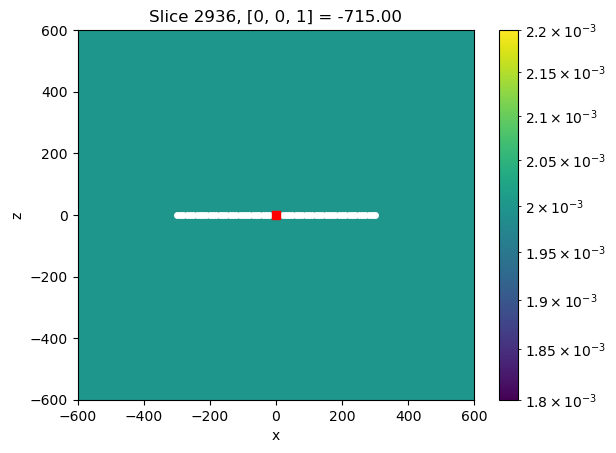

In [18]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=2936
    )[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(600*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.plot(rx_locs[src_ind, 0], rx_locs[src_ind, 1], "rs", ms=6)

In [19]:
observed_data[src, src.receiver_list[0]]

array([-1.363648e-07, -7.809372e-08, -4.325396e-08, -2.542351e-08,
       -1.498345e-08, -8.859146e-09, -5.285972e-09, -3.160718e-09,
       -1.820951e-09, -1.083285e-09, -6.187722e-10, -3.413482e-10,
       -1.840301e-10, -9.564543e-11, -5.253480e-11, -2.856266e-11,
       -1.545211e-11, -8.205196e-12, -4.620991e-12, -2.550408e-12])

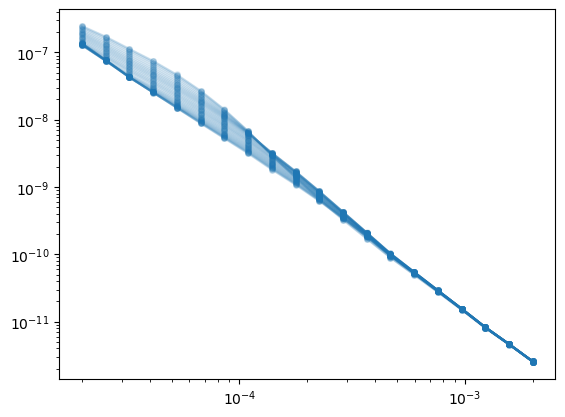

In [20]:
for src_ind in range(len(rx_locs)): 
    src = full_survey.source_list[src_ind]
    
    # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
    plt.loglog(rx_times, -observed_data[src, src.receiver_list[0]], "C0-o", ms=4, alpha=0.1)

In [21]:
src_ind = int(len(rx_locs)/2)
src_ind

30

In [24]:

source_sounding = full_survey.source_list[src_ind]
survey_sounding = tdem.Survey([source_sounding])
sim1d_true = tdem.Simulation1DLayered(
    survey=survey_sounding, thicknesses=[], sigmaMap=maps.IdentityMap(nP=1)
)

In [25]:
dpred_halfspace = sim1d_true.dpred(1./500)

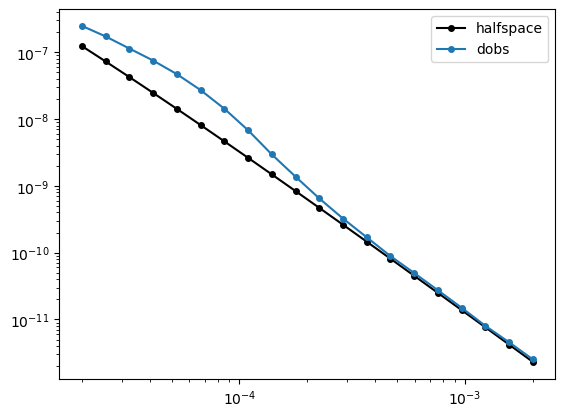

In [26]:
fig, ax = plt.subplots(1, 1)

ax.loglog(rx_times, -dpred_halfspace, "k-o", ms=4, label="halfspace")
ax.loglog(rx_times, -observed_data[source_sounding, source_sounding.receiver_list[0]], "C0-o", ms=4, label="dobs")

ax.legend()

In [27]:
# octree_mesh = discretize.load_mesh("./synthetic-data/treemesh.json")

# octree_mesh = discretize.load_mesh()

In [28]:
cs = 10
core_region = 100
npad = 15
padding_factor = 1.3

thicknesses1d = discretize.utils.unpack_widths(
    [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
)

In [29]:
np.sum(thicknesses1d)


np.float64(2274.7220306106005)

In [39]:
# set up 1D inversion 
def create_inversion(
    ind,
    dobs,
    rx_times_invert=rx_times[:n_times_invert],
    rx_locs=rx_locs, 
    relative_error=0.05,
    noise_floor=1e-12,
    alpha_s = 1e-1,
    alpha_x = 1,
    rho_back = 500,
    beta0 = 200,
): 
    cs = 10
    core_region = 100
    npad = 15
    padding_factor = 1.3
    
    thicknesses1d = discretize.utils.unpack_widths(
        [(cs, np.int64(np.ceil(core_region/cs))), (cs, npad, padding_factor)]
    )
    
    rx_sounding = tdem.receivers.PointMagneticFluxTimeDerivative(
        locations=rx_locs[ind, :], times=rx_times_invert, orientation="z"
    )
    src_sounding = tdem.sources.CircularLoop(
        receiver_list=[rx_sounding], location=rx_locs[ind, :], orientation="z", 
        radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    survey_sounding = tdem.Survey([src_sounding])
    mesh_invert = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")
    
    sim1d = tdem.Simulation1DLayered(
        survey=survey_sounding, thicknesses=thicknesses1d, sigmaMap=maps.ExpMap(mesh_invert)
    )

    data_invert = Data(
        survey_sounding, 
        dobs=dobs,
        standard_deviation=relative_error*np.abs(dobs) + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_invert, alpha_s=alpha_s, alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=20)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=beta0)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False,
    )
    
    
    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        update_jacobi,
        # starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [40]:
len(rx_locs)

61

In [41]:
ind = 30
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], 
    rx_times[:n_times_invert], rx_locs
)

In [42]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  1.50e+03  0.00e+00  1.50e+03    7.85e+02      0              
   1  1.33e+02  6.01e+02  1.34e+00  7.80e+02    3.13e+02      0              
   2  8.89e+01  3.55e+02  2.35e+00  5.64e+02    1.90e+02      0              
   3  5.93e+01  2.68e+02  3.02e+00  4.47e+02    1.22e+02      

In [43]:
iterations = len(inv.directiveList.dList[-2].outDict)

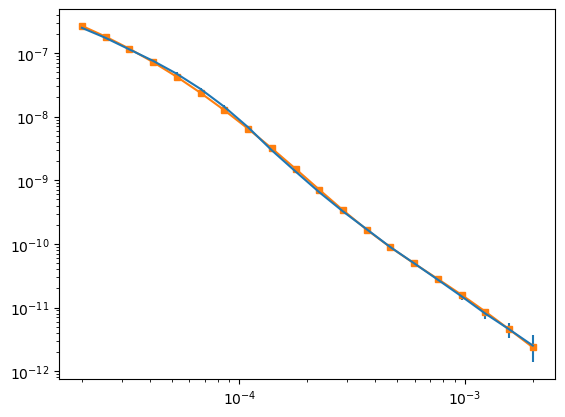

In [44]:

# plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
rx_times_invert = rx_times[:n_times_invert]
plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

(1e-05, 0.1)

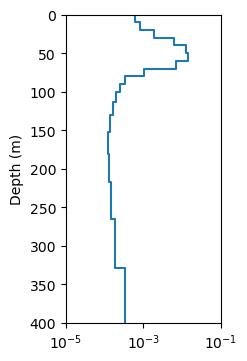

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
# plot_1d_layer_model(
#     thicknesses_true, sigma_true, ax=ax, color="k", label="true"
# )
ax.set_ylim([400, 0])
ax.set_xlim([1e-5, 1e-1])


In [46]:

ind = 0
source_sounding = full_survey.source_list[ind]
inv = create_inversion(
    ind, observed_data[source_sounding, source_sounding.receiver_list[0]], rx_times[:n_times_invert], rx_locs
)

In [47]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
mopt = inv.run(m0)



Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  1.28e+02  0.00e+00  1.28e+02    4.11e+02      0              
   1  1.33e+02  2.15e+01  1.14e-01  3.67e+01    3.57e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2937e+01
1 : |xc-x_last| = 1.3759e

(0.0001, 0.1)

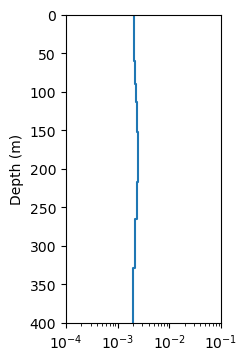

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(2, 4))
plot_1d_layer_model(
    thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
)
# plot_1d_layer_model(
#     thicknesses_true, sigma_true, ax=ax, color="k", label="true"
# )
ax.set_ylim([400, 0])
ax.set_xlim([1e-4, 1e-1])


In [49]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)

In [50]:
directory = "/t40array/lheagy/2025-heagy-et-al-tle/compact-target"

In [51]:
def run_inv(ind, dobs, m0, directory=directory): 
    inv = create_inversion(ind, dobs)
    
    label_key=f"{ind}"
    
    mopt = inv.run(m0)
    np.save(f"{directory}/{label_key}_model.npy", mopt)
    
    inv_dict = inv.directiveList.dList[-2].outDict
    with open(f"{directory}/{label_key}_inv_dict.pkl", "wb") as f:
        pickle.dump(inv_dict, f)

    return label_key, mopt

In [52]:
ind=0
src = full_survey.source_list[ind]
rx = src.receiver_list[0]
run_inv(0, observed_data[src, rx], m0, directory)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+02  1.28e+02  0.00e+00  1.28e+02    4.11e+02      0              
   1  1.33e+02  2.15e+01  1.14e-01  3.67e+01    3.57e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2937e+01
1 : |xc-x_last| = 1.3759e

('0',
 array([-6.17182625, -6.17102376, -6.16911316, -6.16586234, -6.16109045,
        -6.15453764, -6.14593813, -6.13511286, -6.12204457, -6.10687811,
        -6.08739504, -6.061367  , -6.03128583, -6.00654173, -6.00568325,
        -6.04560401, -6.12124387, -6.20660799, -6.274025  , -6.30245192,
        -6.2773793 , -6.22175064, -6.19620269, -6.20060048, -6.21014835,
        -6.21493583]))

In [53]:
from joblib import Parallel, delayed
inv_dict = {}
results = Parallel(n_jobs=48, backend='loky')(  # 'loky' is the default and most flexible
    delayed(run_inv)(
        ind, observed_data[full_survey.source_list[ind], 
        full_survey.source_list[ind].receiver_list[0]], 
        m0, directory)
    for ind in range(rx_locs.shape[0])
)

# Collect results
for (label_key, mopt) in results:
    inv_dict[label_key] = mopt

In [54]:
def load_models_and_dicts(folder):
    inv_dicts = {}
    model_arrays = {}

    for fname in os.listdir(folder):
        full_path = os.path.join(folder, fname)

        if fname.endswith("_inv_dict.pkl"):
            key = fname.replace("_inv_dict.pkl", "")
            with open(full_path, "rb") as f:
                inv_dicts[key] = pickle.load(f)

        elif fname.endswith("_model.npy"):
            key = fname.replace("_model.npy", "")
            model_arrays[key] = np.load(full_path)

    return inv_dicts, model_arrays

In [55]:
inv_dicts, models_1d = load_models_and_dicts(directory)

In [56]:
mesh1d = discretize.TensorMesh([(np.r_[thicknesses1d, thicknesses1d[-1]])], origin="0")


In [57]:
mesh1d.cell_centers

array([   5.        ,   15.        ,   25.        ,   35.        ,
         45.        ,   55.        ,   65.        ,   75.        ,
         85.        ,   95.        ,  106.5       ,  121.45      ,
        140.885     ,  166.1505    ,  198.99565   ,  241.694345  ,
        297.2026485 ,  369.36344305,  463.17247596,  585.12421875,
        743.66148438,  949.7599297 , 1217.6879086 , 1565.99428118,
       2018.79256554, 2530.65149568])

In [58]:
rx_x = np.unique(rx_locs[:, 0])
rx_y = np.unique(rx_locs[:, 1])

In [59]:
grid_1d_results = discretize.utils.ndgrid(
    rx_x, rx_y, -mesh1d.cell_centers
)

In [60]:
compiled_1d_models = np.zeros(len(grid_1d_results))

for key in models_1d.keys():
    ind = int(key)
    m = models_1d[key]
    sounding_inds = (
        (rx_locs[ind, 0] == grid_1d_results[:, 0]) & 
        (rx_locs[ind, 1] == grid_1d_results[:, 1])
    )
    compiled_1d_models[sounding_inds] = np.flipud(m)

In [61]:
hx = np.diff(rx_x)
hx = np.r_[hx, hx[-1]]
# hy = np.diff(rx_y)
# hy = np.r_[hy, hy[-1]]

mesh_results = discretize.TensorMesh(
    [hx, np.flipud(mesh1d.h[0])], origin="CN"
)

In [62]:
mesh_results

TensorMesh: 1,586 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     61       -305.00        305.00     10.00     10.00    1.00
   y     26     -2,786.58          0.00     10.00    511.86    1.30

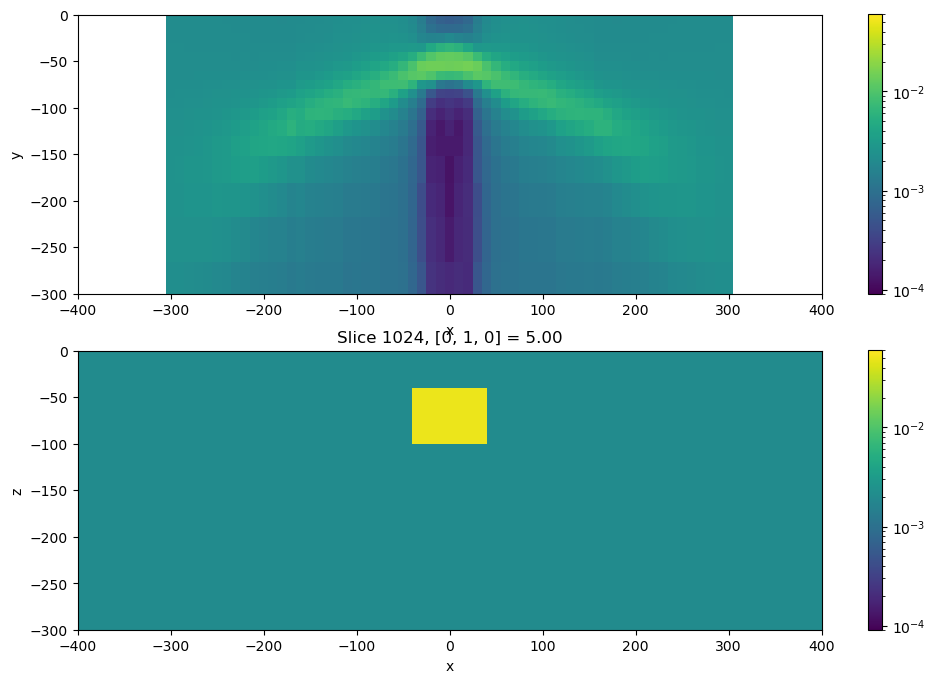

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

norm = LogNorm(vmin=9e-5, vmax=6e-2)
plt.colorbar(mesh_results.plot_image(
    np.exp(compiled_1d_models),
    # normal="Y", 
    pcolor_opts={"norm":norm},
    ax=ax[0],
    # ind=8
)[0], ax=ax[0])


plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":norm}, 
        normal="Y",
    )[0], 
    ax=ax[1]
)


for a in ax.flatten():
    # a.plot(target_outline_x, target_outline_z, color="k", lw=1.5)
    a.set_ylim(-300, 0)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_aspect(1)


In [64]:
dpred_1d = np.zeros((n_times_invert, len(rx_locs)))

for k in inv_dicts.keys():
    ind = int(k)
    
    idict = inv_dicts[k]
    iterations = len(idict)
    dpred_1d[:, ind] = idict[iterations]["dpred"]

    

In [65]:
dpred_1d = dpred_1d.reshape(n_times_invert, len(rx_x), len(rx_y), order="F")

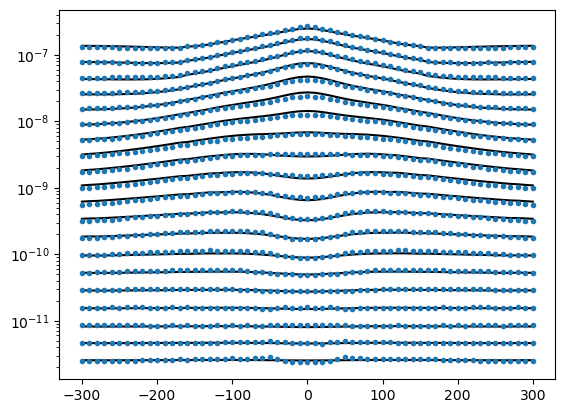

In [66]:
fig, ax = plt.subplots(1, 1)

line_number = 0

ax.semilogy(
    rx_x, -observed_data.dobs.reshape(len(rx_locs[:,0]), 20)[line_number*len(rx_x):(1+line_number)*len(rx_x), :], 
    "k-", ms=3
);

ax.semilogy(rx_x, -dpred_1d[:, :, line_number].T, "C0o", ms=3);

In [80]:
mrec3d = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv.con")

In [81]:
target_x = np.r_[-40, 40]
target_z = np.r_[-100, -40]

target_outline_x = np.r_[
    target_x.min(), target_x.min(), target_x.max(), target_x.max(), target_x.min()
]

target_outline_z = np.r_[
    target_z.min(), target_z.max(), target_z.max(), target_z.min(), target_z.min()
]

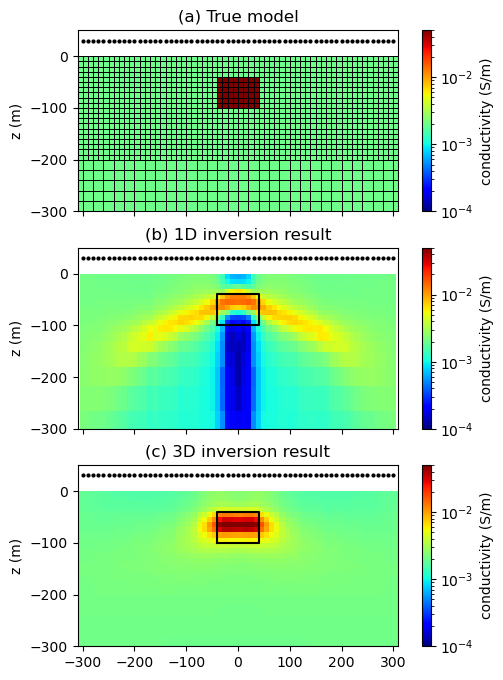

In [84]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

line=0

pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=1/20), "cmap":"jet"}

model_plot = model.copy()
model_plot[model_plot == 1e-8] = np.nan
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        model_plot, ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[0]
)
cb.set_label("conductivity (S/m)")

mrec1d_plot = np.exp(compiled_1d_models.copy())
mrec1d_plot[mrec1d_plot < 9e-7] = np.nan
cb = plt.colorbar(mesh_results.plot_image(
    mrec1d_plot,
    # normal="Y", 
    pcolor_opts=pcolor_opts,
    ax=ax[1],
    # ind=8
)[0], ax=ax[1])
cb.set_label("conductivity (S/m)")

mrec3d_plot = mrec3d.copy()
mrec3d_plot[mrec3d_plot == 1e-8] = np.nan
cb = plt.colorbar(
    ubc_mesh.plot_slice(
        mrec3d_plot, ax=ax[2], pcolor_opts=pcolor_opts, 
        normal="y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[2],
)
cb.set_label("conductivity (S/m)")

ax[0].set_title("(a) True model")
ax[1].set_title("(b) 1D inversion result")
ax[2].set_title("(c) 3D inversion result")

for a in ax[1:]: 
    a.plot(target_outline_x, target_outline_z, color="k")

for a in ax.flatten(): 
    a.set_xlim(310*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 50])
    a.plot(rx_locs[line*len(rx_x):(line+1)*len(rx_x), 0], rx_locs[line*len(rx_x):(line+1)*len(rx_x), 2], "ko", ms=2)
    a.set_aspect(1)
    a.set_xlabel("")
    a.set_ylabel("z (m)")